## In total, there are three implementations conducted, the first one is sumbitted on the ppt. The others are presented as backup. 

# 1. Conducting K-Means Clustering based on the Frequency and the Monetary values of the EFOOD dataset

In [1]:
import pandas as pd 
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [2]:
#Read the dataset
df = pd.read_csv('C:/Users/Alexandros Ntzoufas/Desktop/MSC in BA/EFOOD/bq-results-20210331-234015-dd03acfaj8vo.csv')

In [3]:
df.head()

,order_id,brand,submit_dt,user_id,shop_id,city,cuisine_parent,basket
0,2846837765,GR-EFOOD,2021-01-13 20:37:06 UTC,99103596,206490318,Βόλος,Healthy / Other,9.0
1,2878146359,GR-EFOOD,2021-01-22 14:28:57 UTC,77179398,206490318,Βόλος,Healthy / Other,7.0
2,2904155390,GR-EFOOD,2021-01-29 13:52:24 UTC,7233822,206490318,Βόλος,Healthy / Other,6.3
3,2867086278,GR-EFOOD,2021-01-19 12:19:59 UTC,68621466,206490318,Βόλος,Healthy / Other,7.0
4,2875723043,GR-EFOOD,2021-01-21 20:08:59 UTC,17007258,206490318,Βόλος,Healthy / Other,11.8


In [4]:
#Check for null values
df.isnull().sum()

order_id          0
brand             0
submit_dt         0
user_id           0
shop_id           0
city              0
cuisine_parent    0
basket            0
dtype: int64

In [5]:
df.describe()

,order_id,user_id,shop_id,basket
count,4.000000e+05,4.000000e+05,4.000000e+05,400000.000000
mean,2.859831e+09,7.681345e+07,1.570035e+08,8.723202
std,3.254756e+07,5.392006e+07,1.214792e+08,6.535030
min,2.803070e+09,2.746200e+04,1.088100e+04,0.000000
25%,2.831813e+09,3.346865e+07,4.499470e+07,4.480000
50%,2.860131e+09,6.733682e+07,1.423500e+08,6.800000
75%,2.888153e+09,1.069124e+08,2.365069e+08,11.200000
max,2.915729e+09,1.982852e+08,3.996849e+08,151.850000


In [6]:
#Examine the values of cuisine parent
df['cuisine_parent'].value_counts()

Breakfast          150341
Meat               113879
Italian             52733
Street food         30587
Creperie            25046
Traditional         15042
Ethnic               8628
Sweets               2845
Healthy / Other       899
Name: cuisine_parent, dtype: int64

In [7]:
#Counting the frequency and summing the basket by user id
fm_efood = df.groupby(['user_id']).agg({
    'order_id': 'count',
    'basket': 'sum'})

In [8]:
#Rename columns 
fm_efood.rename(columns ={ 'order_id':'frequency', 'basket':'monetary'}, inplace=True)
fm_efood['monetary']=fm_efood['monetary'].round(1)

In [9]:
fm_efood.head()

,frequency,monetary
user_id,,
27462,1,10.6
39238,2,35.0
41354,4,29.0
44068,1,19.5
49220,1,5.3


C:\Users\Alexandros Ntzoufas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


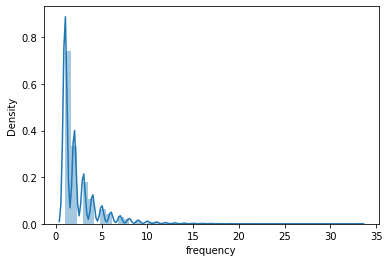

In [10]:
sns.distplot(fm_efood.frequency)

C:\Users\Alexandros Ntzoufas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


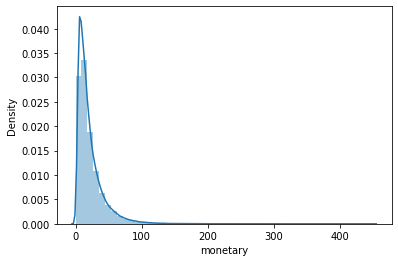

In [11]:
sns.distplot(fm_efood.monetary)


In [12]:
#Scalling the data since we have different ranged variables
scaler = StandardScaler()
efood_std=scaler.fit_transform(fm_efood)

In [13]:
#Apply K-Means to define the number of clusters
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(efood_std)
    wcss.append(kmeans.inertia_)

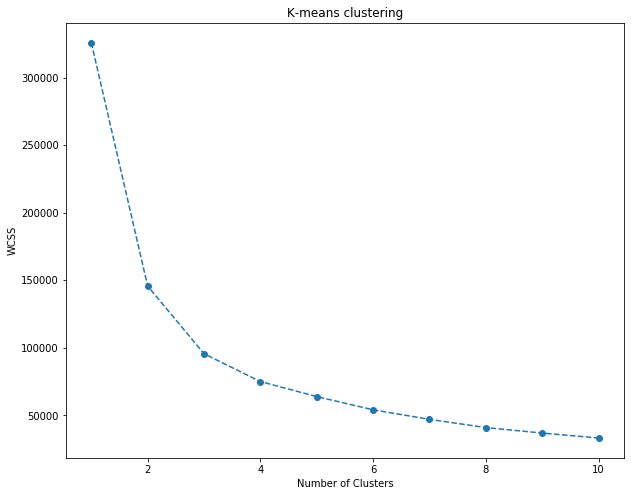

In [14]:
#Elbow method - For evaluating and determine the number of the clusters
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means clustering')
plt.show()

In [15]:
#Fitting the kmeans model with 4 clusters
kmeans=KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(efood_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [16]:
#Copying the dataset and make a new with the K-means clusters / segments
df_segm=fm_efood.copy()
df_segm['Segment K-means']=kmeans.labels_

In [17]:
df_segm.head()

,frequency,monetary,Segment K-means
user_id,,,
27462,1,10.6,0
39238,2,35.0,2
41354,4,29.0,2
44068,1,19.5,0
49220,1,5.3,0


In [18]:
#Save it to disc in order to further visualize with BI tools
#df_segm.to_csv('C:/Users/Alexandros Ntzoufas/Desktop/MSC in BA/EFOOD/Kmeans_segm.csv')

In [19]:
#Calculating the number of observation of each segment and the % proportion 
df_segm_analysis=df_segm.groupby(['Segment K-means']).mean()
df_segm_analysis['N Obs']=df_segm[['Segment K-means','frequency']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs']=df_segm_analysis['N Obs']/df_segm_analysis['N Obs'].sum()

In [20]:
df_segm_analysis.head()

,frequency,monetary,N Obs,Prop Obs
Segment K-means,,,,
0,1.261229,10.501810,98580,0.604956
1,6.041245,51.430829,16705,0.102514
2,2.979497,27.984481,43799,0.268781
3,11.434109,95.393773,3870,0.023749


In [21]:
# Rename the Segments
df_segm_analysis.rename({0:'Occasional Customers', 
                       1:'Frequent Customers', 
                        2:'Starndard Customers', 
                        3:'Golden Members'})

,frequency,monetary,N Obs,Prop Obs
Segment K-means,,,,
Occasional Customers,1.261229,10.501810,98580,0.604956
Frequent Customers,6.041245,51.430829,16705,0.102514
Starndard Customers,2.979497,27.984481,43799,0.268781
Golden Members,11.434109,95.393773,3870,0.023749


C:\Users\Alexandros Ntzoufas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


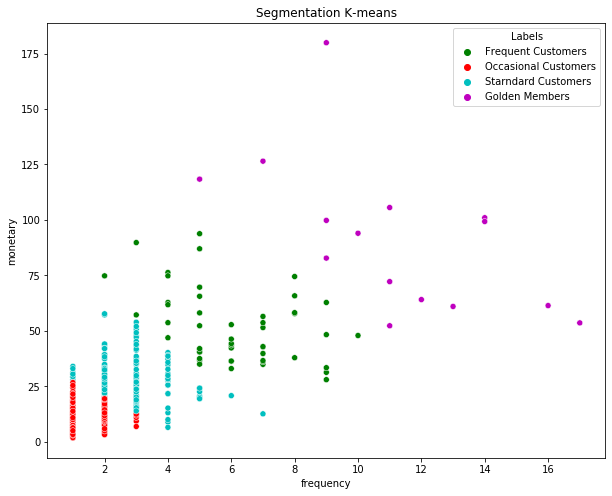

In [22]:
#Visualize a random sample of the dataset
#Since we have descrete values of Frequency, with high number of observations, the values are overwritten, thats why use the sample
df_segm_vis=df_segm.sample(500, random_state=11)
df_segm_vis['Labels']=df_segm_vis['Segment K-means'].map({0:'Occasional Customers', 
                       1:'Frequent Customers', 
                        2:'Starndard Customers', 
                        3:'Golden Members'})


x_axis=df_segm_vis['frequency']
y_axis=df_segm_vis['monetary']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis, hue=df_segm_vis['Labels'], palette=['g', 'r', 'c','m'])
plt.title('Segmentation K-means')
plt.show()

# 2. Performing customer segmentation with quantiles assessment - Distinguish the customers' segments based on the their frequency and monetary values by rating them

In [23]:
#Defining the 4 quantiles
quartiles = fm_efood.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))
quartiles=quartiles.to_dict()
quartiles

      frequency  monetary
0.25        1.0       8.4
0.50        2.0      15.2
0.75        3.0      27.4 <class 'pandas.core.frame.DataFrame'>


{'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'monetary': {0.25: 8.4, 0.5: 15.2, 0.75: 27.4}}

In [24]:
# Rating the customers based on the Frequency and Monetary value - The higher the FM value, the higher the rating 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4 

rfmSeg = fm_efood
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary'].apply(FMClass, args=('monetary',quartiles,))

In [25]:
#Total table with total score and labels of the clusters 

rfmSeg['Total Score'] =  rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
rfmSeg.head()

,frequency,monetary,F_Quartile,M_Quartile,Total Score
user_id,,,,,
27462,1,10.6,1,2,3
39238,2,35.0,2,4,6
41354,4,29.0,4,4,8
44068,1,19.5,1,3,4
49220,1,5.3,1,1,2


In [26]:
def label(x):
    if x<=2:
        return 0
    elif x<=4:
        return 1
    elif x<=6:
        return 2
    else: return 3
rfmSeg['Label'] = rfmSeg['Total Score'].apply(label)

In [27]:
rfmSeg.head()

,frequency,monetary,F_Quartile,M_Quartile,Total Score,Label
user_id,,,,,,
27462,1,10.6,1,2,3,1
39238,2,35.0,2,4,6,2
41354,4,29.0,4,4,8,3
44068,1,19.5,1,3,4,1
49220,1,5.3,1,1,2,0


In [28]:
rfmSeg['Label']=rfmSeg['Label'].map({0:'Occasional Customers', 
                       1: 'Standard Customers',
                        2:'Frequent Customers', 
                        3:'Golden Members'})

In [29]:
rfmSeg

,frequency,monetary,F_Quartile,M_Quartile,Total Score,Label
user_id,,,,,,
27462,1,10.6,1,2,3,Standard Customers
39238,2,35.0,2,4,6,Frequent Customers
41354,4,29.0,4,4,8,Golden Members
44068,1,19.5,1,3,4,Standard Customers
49220,1,5.3,1,1,2,Occasional Customers
...,...,...,...,...,...,...
198280516,1,9.9,1,2,3,Standard Customers
198281114,1,13.7,1,2,3,Standard Customers
198283828,1,5.5,1,1,2,Occasional Customers


C:\Users\Alexandros Ntzoufas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


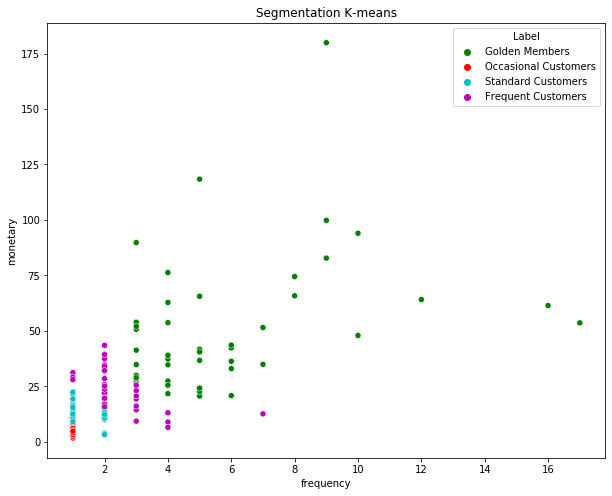

In [30]:
#Visualizing the 4 Clusters

df_segm_vis2=rfmSeg.sample(200, random_state=11)
x_axis=df_segm_vis2['frequency']
y_axis=df_segm_vis2['monetary']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis, hue=df_segm_vis2['Label'], palette=['g', 'r', 'c','m'])
plt.title('Segmentation K-means')
plt.show()

In [31]:
rfmSeg_analysis=rfmSeg.groupby(['Label']).mean()
rfmSeg_analysis['N Obs']=rfmSeg[['Label','frequency']].groupby(['Label']).count()
rfmSeg_analysis['Prop Obs']=rfmSeg_analysis['N Obs']/rfmSeg_analysis['N Obs'].sum()
rfmSeg_analysis

,frequency,monetary,F_Quartile,M_Quartile,Total Score,N Obs,Prop Obs
Label,,,,,,,
Frequent Customers,2.346987,23.966720,2.322780,3.130163,5.452944,34618,0.212440
Golden Members,5.594831,46.379665,3.801424,3.829958,7.631382,37920,0.232704
Occasional Customers,1.000000,5.362143,1.000000,1.000000,2.000000,36627,0.224769
Standard Customers,1.300805,13.097299,1.300805,2.163268,3.464073,53789,0.330087


# 3. Third implementation -  RFM analysis (Recency - Frequency - Monetary) with K-Means

### I tried this implementation since we have date related data. However, the data were only of one month and the description of the case study was mentioning to focus on the frequency and the basket. So I made the implementation just for backup

In [32]:
#Formating the dates column (submit_dt)
df['submit_dt']=df['submit_dt'].str[:10]
df['submit_dt']=pd.to_datetime(df['submit_dt'],format='%Y-%m-%d')

In [33]:
# Formulating the RFM(recency, frequency, monetary) dataset
#Counting the frequency and summing the basket by user id

snap_date = max(df['submit_dt']) + datetime.timedelta(days=1)
rfm_efood = df.groupby(['user_id']).agg({
    'submit_dt': lambda x: (snap_date - x.max()).days,
    'order_id': 'count',
    'basket': 'sum'})

In [34]:
#Rename columns 
rfm_efood.rename(columns ={'submit_dt':'recency', 'order_id':'frequency', 'basket':'monetary'}, inplace=True)
rfm_efood['monetary']=rfm_efood['monetary'].round(1)

In [35]:
rfm_efood.head()

,recency,frequency,monetary
user_id,,,
27462,26,1,10.6
39238,5,2,35.0
41354,4,4,29.0
44068,15,1,19.5
49220,28,1,5.3


In [36]:
#Scalling the data since we have different ranged variables
scaler = StandardScaler()
rfm_std=scaler.fit_transform(rfm_efood)

In [37]:
#Apply K-Means to define the number of clusters
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_std)
    wcss.append(kmeans.inertia_)

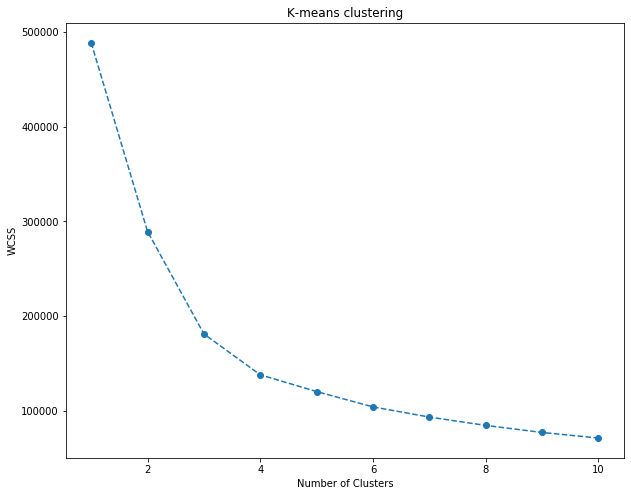

In [38]:
#Elbow method 
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means clustering')
plt.show()

In [39]:
#Kmeans clustering with 4 clusters
kmeans=KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(rfm_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [40]:
#Copy the initial RFM dataset and creating labels 
rfm_segm=rfm_efood.copy()
rfm_segm['Segment K-means']=kmeans.labels_

In [41]:
#Counting the number of observations and the % proportion
rfm_segm_analysis=rfm_segm.groupby(['Segment K-means']).mean()
rfm_segm_analysis['N Obs']=rfm_segm[['Segment K-means','recency']].groupby(['Segment K-means']).count()
rfm_segm_analysis['Prop Obs']=rfm_segm_analysis['N Obs']/rfm_segm_analysis['N Obs'].sum()

In [42]:
rfm_segm_analysis.head()

,recency,frequency,monetary,N Obs,Prop Obs
Segment K-means,,,,,
0,6.697176,1.652213,13.489882,69235,0.424875
1,22.418822,1.306459,12.966295,53968,0.331185
2,3.560748,9.805388,81.037356,7276,0.044651
3,5.771978,4.426728,38.981426,32475,0.199289


In [43]:
#Labeling the 4 Clusters

rfm_segm_vis=rfm_segm.sample(300, random_state=11)
rfm_segm_vis['Labels']=rfm_segm_vis['Segment K-means'].map({0:'Standard Customers', 
                       1:'Occasional Customers', 
                        2:'Frequent Customers', 
                        3:'Golden Members'})
rfm_segm_vis

,recency,frequency,monetary,Segment K-means,Labels
user_id,,,,,
35102278,1,3,89.8,3,Golden Members
50858198,15,1,3.4,1,Occasional Customers
108554756,15,1,4.7,1,Occasional Customers
87636532,9,1,16.4,0,Standard Customers
40705952,1,1,6.5,0,Standard Customers
...,...,...,...,...,...
3832122,11,1,12.5,0,Standard Customers
3579444,7,2,26.5,0,Standard Customers
115659134,28,2,13.8,1,Occasional Customers


C:\Users\Alexandros Ntzoufas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


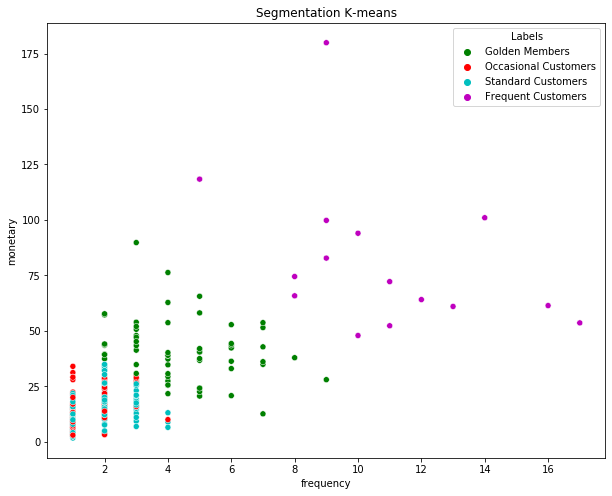

In [44]:
# Visualizing the 4 clusters - Monetary VS Frequency
x_axis=rfm_segm_vis['frequency']
y_axis=rfm_segm_vis['monetary']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis, hue=rfm_segm_vis['Labels'], palette=['g', 'r', 'c','m'])
plt.title('Segmentation K-means')
plt.show()

C:\Users\Alexandros Ntzoufas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


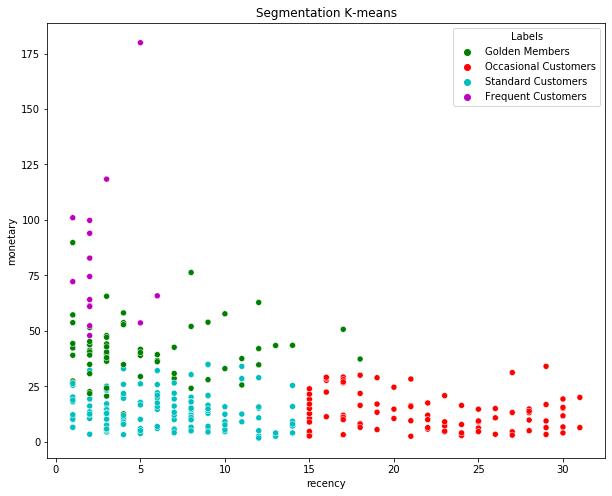

In [45]:
# Visualizing the 4 clusters - Monetary VS Recency

x_axis=rfm_segm_vis['recency']
y_axis=rfm_segm_vis['monetary']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis, hue=rfm_segm_vis['Labels'], palette=['g', 'r', 'c','m'])
plt.title('Segmentation K-means')
plt.show()

C:\Users\Alexandros Ntzoufas\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


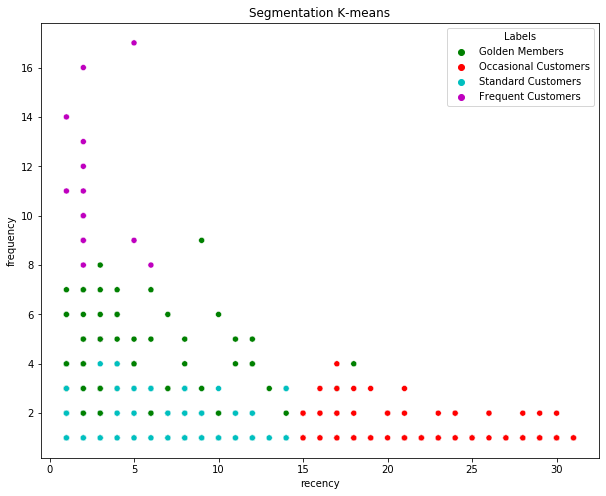

In [46]:
# Visualizing the 4 clusters - Frequency VS Recency

x_axis=rfm_segm_vis['recency']
y_axis=rfm_segm_vis['frequency']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis, hue=rfm_segm_vis['Labels'], palette=['g', 'r', 'c','m'])
plt.title('Segmentation K-means')
plt.show()